### Think through  how to better handle indexing and merging pd_df challenges

This notebook validates using the 60% validation Koumassi dataset (n=604 points)

This is a working notebook to label 8 cluster kmeans result. The labeled map is sampled using the 60% subset of validation samples to identify characteristics of each class (floodwater, shadow, other)

Currently working on trying to separate flood and shadow areas based on perimeter and area characteristics.

In [1]:
# Import packages
import os, sys
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
from glob import glob
import rasterio as rio
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy as et
from skimage import measure
from skimage import morphology

%matplotlib inline

In [2]:
# Set working directory
# os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'flood-detection'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

In [3]:
# # Set directory to area of interest containing raster stack
# aoi = "koumassi_focus_ps"

# # Open existing raster stack
# # band_path = os.path.join("dg-data", aoi +"\\")
# # band_stack_path = os.path.join(band_path, "outputs\\indices_and_mask_files\\")
# # all_bands_path = os.path.join(band_stack_path, aoi + "_all_bands.tif")
# outputs_path = os.path.join("dg-data", aoi ,"outputs", "raster_files\\")
# # kmeans_path = outputs_path+"kmeans_koumassi_focus_ps.tif"
# kmeans_path = outputs_path+"kmeans_with_shadow_mask.tif"
# cluster_path = os.path.join("dg-data",aoi,"outputs","clustering","kmeans")
# valid_data_path = os.path.join("validation")
# valid_60_data = pd.read_csv(valid_data_path+"\\"+"koumassi_validation_data_60_percent.csv")
# sample_pts_path = os.path.join("validation","vector-data")
# sample_pts_60perc = gpd.read_file(sample_pts_path+"\\"+"validation_points_koumassi_60_percent.shp")

# # Create tuples of all x coordinates and y coordinates 
# x_coords = tuple(sample_pts_60perc.geometry.x)
# y_coords = tuple(sample_pts_60perc.geometry.y)

In [4]:
# Set directory to area of interest containing raster stack
aoi = "koumassi_focus_ps"
kmeans_file ="kmeans_with_shadow_mask"
band_path = '..\\data\\'+aoi+"\\"
raster_outputs_path = os.path.join(band_path, "outputs\\raster_files\\")
kmeans_outputs_path = os.path.join(band_path, "outputs\\kmeans\\")
kmeans_path = os.path.join(band_path, "outputs\\kmeans\\"+kmeans_file+".tif")

# Open existing raster stack
# band_path = os.path.join("dg-data", aoi +"\\")
# band_stack_path = os.path.join(band_path, "outputs\\indices_and_mask_files\\")
# all_bands_path = os.path.join(band_stack_path, aoi + "_all_bands.tif")
# outputs_path = os.path.join("dg-data", aoi ,"outputs", "raster_files\\")
# kmeans_path = outputs_path+"kmeans_koumassi_focus_ps.tif"
# kmeans_path = outputs_path+"kmeans_with_shadow_mask.tif"
# cluster_path = os.path.join("dg-data",aoi,"outputs","clustering","kmeans")
# validation_data_path = os.path.join("validation")
# valid_data = pd.read_csv(valid_data_path+"\\"+"koumassi_validation_data_60_percent.csv")
# sample_pts_path = os.path.join("validation","vector-data")
# sample_pts = gpd.read_file(sample_pts_path+"\\"+"validation_points_koumassi_60_percent.shp")

validation_data_path = os.path.join(band_path,'validation\\')
sample_pts_60perc = gpd.read_file(validation_data_path+"vector-data\\validation_points_koumassi_60_percent.shp")
sample_pts_40perc = gpd.read_file(validation_data_path+"vector-data\\validation_points_koumassi_40_percent.shp")
sample_pts_all = gpd.read_file(validation_data_path+"vector-data\\"+"all_koumassi_validation_points.shp")

valid_60_data = pd.read_csv(validation_data_path+"koumassi_validation_data_60_percent.csv")
valid_40_data = pd.read_csv(validation_data_path+"koumassi_validation_data_40_percent.csv")
all_valid_data = pd.read_csv(validation_data_path+"all_koumassi_validation_data.csv")


# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_60perc.geometry.x)
y_coords = tuple(sample_pts_60perc.geometry.y)

In [5]:
# Update these based on looking at what each cluster represents
class8 = 2
class7 = 3 # used 1 here for shadow_build
class6 = 3
class5 = 1
class4 = 3
class3 = 1 # see what validates better 1 or 2
class2 = 3 # choose 1 or 2 for 010
class1 = 3

In [6]:
# Make list of all non-dunder attributes of regionprops object
def scalar_attributes_list(im_props):
    """
    Makes list of all scalar, non-dunder, non-hidden
    attributes of skimage.measure.regionprops object
    """
    
    attributes_list = []
    
    for i, test_attribute in enumerate(dir(im_props[0])):
        
        #Attribute should not start with _ and cannot return an array
        #does not yet return tuples
        if test_attribute[:1] != '_' and not\
                isinstance(getattr(im_props[0], test_attribute), np.ndarray):                
            attributes_list += [test_attribute]
            
    return attributes_list

In [7]:
def regionprops_to_df(im_props):
    """
    Read content of all attributes for every item in a list
    output by skimage.measure.regionprops
    """

    attributes_list = scalar_attributes_list(im_props)

    # Initialise list of lists for parsed data
    parsed_data = []

    # Put data from im_props into list of lists
    for i, _ in enumerate(im_props):
        parsed_data += [[]]
        
        for j in range(len(attributes_list)):
            parsed_data[i] += [getattr(im_props[i], attributes_list[j])]

    # Return as a Pandas DataFrame
    return pd.DataFrame(parsed_data, columns=attributes_list)

In [8]:
valid_60_data.head()

,OBJECTID,ClassValue
0,1,2
1,2,1
2,3,1
3,4,1
4,5,1


In [9]:
# Open kmeans geotiff
with rio.open(kmeans_path) as src:
    kmeans_result = src.read()
    kmeans_meta = src.meta

kmeans_result = np.squeeze(kmeans_result)
kmeans_result.shape

(1668, 1788)

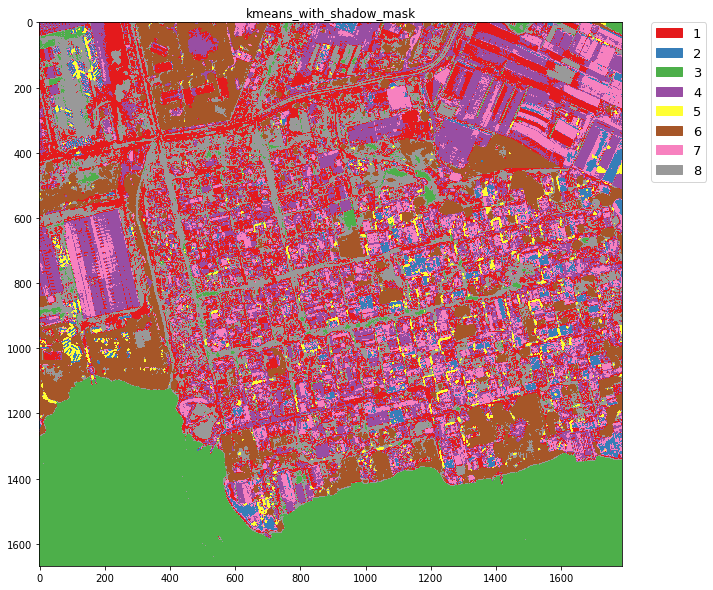

In [10]:
# Label kmeans result
kmeans_labels = measure.label(kmeans_result) 
props = measure.regionprops(kmeans_labels, intensity_image = kmeans_result) 

# Plot kmeans result for verification layer 
fig, ax = plt.subplots(figsize=(20,10))
labeled_plot = ax.imshow(kmeans_result, cmap='Set1')
cat_names = ["1","2","3","4","5","6","7","8"]
ep.draw_legend(labeled_plot,titles=cat_names)
# plt.title("K-means - 8 clusters - 8 bands")
ax.set(title=kmeans_file)
# ax.set_axis_off()
plt.show()

In [11]:
# write out labeled kmeans files
kmeans_labels_out = kmeans_labels[np.newaxis,:]
with rio.open(kmeans_outputs_path+kmeans_file+'_labeled.tif', 'w', **kmeans_meta) as dst:
    dst.write(kmeans_labels_out.astype('float32'))

Utilize functions from regionprops_to_df

In [12]:
# Convert regionprops to df 
props_df = regionprops_to_df(props)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


In [13]:
# make sure re-ordering is not an issue
props_df.index = props_df.index+1
props_df.index.name='object_id'
props_df['labels_original']=props_df.index
props_df.head()

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,major_axis_length,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original
object_id,,,,,,,,,,,,,,,,,,,,,
1,92,"(0, 0, 28, 7)",196,"(15.065217391304348, 1.934782608695652)",119,0.981582,10.823033,0,0.469388,93,...,28.145498,4.0,4.0,4.0,5.377009,-1.421294,59.106602,0.773109,"(15.065217391304348, 1.934782608695652)",1
2,2,"(0, 1, 2, 2)",2,"(0.5, 1.0)",2,1.000000,1.595769,1,1.000000,2,...,2.000000,1.0,1.0,1.0,0.000000,-1.570796,0.000000,1.000000,"(0.5, 1.0)",2
3,12,"(0, 2, 11, 5)",33,"(5.25, 2.9166666666666665)",18,0.995810,3.908820,1,0.363636,12,...,12.864875,8.0,8.0,8.0,1.176379,-1.350479,10.414214,0.666667,"(5.25, 2.9166666666666665)",3
4,2501,"(0, 3, 37, 149)",5402,"(11.4234306277489, 65.50739704118352)",3263,0.978762,56.430241,-16,0.462977,2621,...,148.765364,4.0,4.0,4.0,30.496979,0.076949,817.392965,0.766473,"(11.4234306277489, 65.50739704118352)",4
5,1,"(0, 12, 1, 13)",1,"(0.0, 12.0)",1,0.000000,1.128379,1,1.000000,1,...,0.000000,8.0,8.0,8.0,0.000000,0.785398,0.000000,1.000000,"(0.0, 12.0)",5


### Sample with 60% of data

In [14]:
#delete this
# kmeans_labels_path = outputs_path+"kmeans_labels_koumassi_focus_ps.tif"

In [15]:
# Use rasterio sample method to pull label numbers for 60% reference dataset. 
kmeans_labeled_path = kmeans_outputs_path+kmeans_file+'_labeled.tif'
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_labeled_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
# Dataframe includes label number for each reference point
kmeans_labeled_60_df = pd.DataFrame(arr)
kmeans_labeled_60_df.index=kmeans_labeled_60_df.index+1
kmeans_labeled_60_df.head()

,0
1,30795.0
2,25767.0
3,27261.0
4,27261.0
5,46937.0


In [16]:
# # Sample from labeled map (kmeans_labels)
# sampled_values = []

# # Sample raster at each combo of x and y coordinates
# with rio.open(kmeans_path) as src:
# #     src = np.squeeze(src)
#     for val in src.sample(zip(x_coords, y_coords)):
        
#         # Note that each val is an individual numpy array
#         #print(val.shape)
#         sampled_values.append(val)
        
# # Convert list to one-dimensional array
# arr = np.array([sampled_values]).squeeze()
# # print(arr)

# # Convert array to dataframe

# kmeans_df = pd.DataFrame(arr)
# kmeans_df.head()

In [17]:
# valid_60_data.index=valid_60_data.index+1
valid_60_data.head()

,OBJECTID,ClassValue
0,1,2
1,2,1
2,3,1
3,4,1
4,5,1


In [18]:
# labels_valid_data = [kmeans_labels_df,valid_data]
labeled_valid_60_data_df = pd.concat([kmeans_labeled_60_df,valid_60_data], axis=1, sort=False)
labeled_valid_60_data_df.columns = ["labels","object_id","validation_data"]
labeled_valid_60_data_df = labeled_valid_60_data_df.drop_duplicates(subset="labels")
labeled_valid_60_data_df = labeled_valid_60_data_df.sort_values(by="labels")
# labels_clusters_df_nodups
# labels_valid_data_df.index=labels_valid_data_df.index+1
labeled_valid_60_data_df.head()

,labels,object_id,validation_data
524,27.0,525.0,3.0
536,38.0,537.0,3.0
532,159.0,533.0,3.0
53,195.0,54.0,1.0
434,282.0,435.0,3.0


### Look into addressing this warning

In [19]:
# Subset props dataset to focus only on 60% validation data
subset_props_labels = props_df[props_df.index.isin(labeled_valid_60_data_df['labels'])]
# subset_props_labels = props_df.loc[props_df['labels_original']==labeled_valid_60_data_df['labels']]
# subset_props_labels = subset_props_labels.join(labels_clusters_df_nodups)     
subset_props_labels['labels']=subset_props_labels.index
# rst = rpt[rpt['STK_ID'].isin(stk_list)].
subset_props_labels.head()

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels
object_id,,,,,,,,,,,,,,,,,,,,,
27,98708,"(0, 0, 500, 1075)",537500,"(254.09218097823884, 487.70105766503224)",458985,0.923445,354.512241,-1057,0.183643,112255,...,1.0,1.0,1.0,458.785194,0.070743,39259.913903,0.215057,"(254.09218097823884, 487.70105766503224)",27,27
38,64193,"(0, 297, 332, 701)",134128,"(144.16297727166514, 485.4574486314707)",99494,0.249540,285.889955,-157,0.478595,75349,...,6.0,6.0,6.0,372.823977,0.704744,7718.476077,0.645195,"(144.16297727166514, 485.4574486314707)",38,38
159,11691,"(0, 1327, 145, 1640)",45385,"(70.49097596441707, 1505.030279702335)",27872,0.939195,122.005916,-86,0.257596,12117,...,4.0,4.0,4.0,110.610458,-0.049923,3530.747617,0.419453,"(70.49097596441707, 1505.030279702335)",159,159
195,29,"(1, 1049, 23, 1058)",198,"(12.068965517241379, 1052.6206896551723)",49,0.997840,6.076508,1,0.146465,29,...,3.0,3.0,3.0,1.684209,1.187798,28.485281,0.591837,"(12.068965517241379, 1052.6206896551723)",195,195
282,1,"(4, 1659, 5, 1660)",1,"(4.0, 1659.0)",1,0.000000,1.128379,1,1.000000,1,...,3.0,3.0,3.0,0.000000,0.785398,0.000000,1.000000,"(4.0, 1659.0)",282,282


In [20]:
subset_props = pd.merge(subset_props_labels,labeled_valid_60_data_df, on='labels')
subset_props.head()

# props_labels_clusters = subset_props_labels[subset_props_labels.index.isin(labels_clusters_df('labels'))].add(labels_clusters_df('clusters'))

# props_labels_clusters = subset_props_labels.merge(labels_clusters_df, on='labels')
# props_labels_clusters = labels_clusters_df.join(subset_props_labels.set_index('object_id').bar.rename('new'))

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels,object_id,validation_data
0,98708,"(0, 0, 500, 1075)",537500,"(254.09218097823884, 487.70105766503224)",458985,0.923445,354.512241,-1057,0.183643,112255,...,1.0,458.785194,0.070743,39259.913903,0.215057,"(254.09218097823884, 487.70105766503224)",27,27,525.0,3.0
1,64193,"(0, 297, 332, 701)",134128,"(144.16297727166514, 485.4574486314707)",99494,0.249540,285.889955,-157,0.478595,75349,...,6.0,372.823977,0.704744,7718.476077,0.645195,"(144.16297727166514, 485.4574486314707)",38,38,537.0,3.0
2,11691,"(0, 1327, 145, 1640)",45385,"(70.49097596441707, 1505.030279702335)",27872,0.939195,122.005916,-86,0.257596,12117,...,4.0,110.610458,-0.049923,3530.747617,0.419453,"(70.49097596441707, 1505.030279702335)",159,159,533.0,3.0
3,29,"(1, 1049, 23, 1058)",198,"(12.068965517241379, 1052.6206896551723)",49,0.997840,6.076508,1,0.146465,29,...,3.0,1.684209,1.187798,28.485281,0.591837,"(12.068965517241379, 1052.6206896551723)",195,195,54.0,1.0
4,1,"(4, 1659, 5, 1660)",1,"(4.0, 1659.0)",1,0.000000,1.128379,1,1.000000,1,...,3.0,0.000000,0.785398,0.000000,1.000000,"(4.0, 1659.0)",282,282,435.0,3.0


In [21]:
## Have to update based on results from kmeans

In [22]:
accuracy_kmeans = pd.concat([subset_props['min_intensity'],subset_props['validation_data']], axis=1, sort=False)
# accuracy_score = pd.concat([valid_data,index_comb_df], axis=1, sort=False)
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 8.0,"new"] = class8
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 7.0,"new"] = class7
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 6.0,"new"] = class6
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 5.0,"new"] = class5
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 4.0,"new"] = class4
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 3.0,"new"] = class3
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 2.0,"new"] = class2
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 1.0,"new"] = class1
accuracy_kmeans.head()

,min_intensity,validation_data,new
0,1.0,3.0,3.0
1,6.0,3.0,3.0
2,4.0,3.0,3.0
3,3.0,1.0,1.0
4,3.0,3.0,1.0


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
ytest = accuracy_kmeans['validation_data']
ypred = accuracy_kmeans['new']
accuracy_score(ytest, ypred)

0.788659793814433

[[183  28   0]
 [ 41  24   8]
 [  1   4  99]]


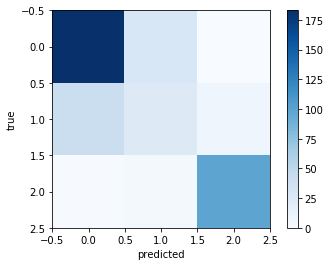

In [24]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

# Sample with 40%

In [25]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_40perc.geometry.x)
y_coords = tuple(sample_pts_40perc.geometry.y)

In [26]:
# Use rasterio sample method to pull label numbers for 60% reference dataset. 
# kmeans_labeled_path = kmeans_outputs_path+kmeans_file+'_labeled.tif'
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_labeled_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
# Dataframe includes label number for each reference point
kmeans_labeled_40_df = pd.DataFrame(arr)
kmeans_labeled_40_df.index=kmeans_labeled_40_df.index+1
kmeans_labeled_40_df.head()

,0
1,30795.0
2,24820.0
3,27261.0
4,46937.0
5,48671.0


In [27]:
# labels_valid_data = [kmeans_labels_df,valid_data]
labeled_valid_40_data_df = pd.concat([kmeans_labeled_40_df,valid_40_data], axis=1, sort=False)
labeled_valid_40_data_df.columns = ["labels","object_id","validation_data"]
labeled_valid_40_data_df = labeled_valid_40_data_df.drop_duplicates(subset="labels")
labeled_valid_40_data_df = labeled_valid_40_data_df.sort_values(by="labels")
# labels_clusters_df_nodups
# labels_valid_data_df.index=labels_valid_data_df.index+1
labeled_valid_40_data_df.head()

,labels,object_id,validation_data
367,38.0,368.0,3.0
31,108.0,32.0,2.0
366,159.0,367.0,3.0
365,1757.0,366.0,3.0
368,1919.0,369.0,3.0


In [28]:
# Subset props dataset to focus only on 60% validation data
subset_props_labels = props_df[props_df.index.isin(labeled_valid_40_data_df['labels'])]
# subset_props_labels = props_df.loc[props_df['labels_original']==labeled_valid_60_data_df['labels']]
# subset_props_labels = subset_props_labels.join(labels_clusters_df_nodups)     
subset_props_labels['labels']=subset_props_labels.index
# rst = rpt[rpt['STK_ID'].isin(stk_list)].
subset_props_labels.head()

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels
object_id,,,,,,,,,,,,,,,,,,,,,
38,64193,"(0, 297, 332, 701)",134128,"(144.16297727166514, 485.4574486314707)",99494,0.249540,285.889955,-157,0.478595,75349,...,6.0,6.0,6.0,372.823977,0.704744,7718.476077,0.645195,"(144.16297727166514, 485.4574486314707)",38,38
108,145,"(0, 1040, 44, 1059)",836,"(23.26896551724138, 1048.3517241379311)",255,0.993505,13.587484,-1,0.173445,158,...,8.0,8.0,8.0,5.871097,1.238609,121.870058,0.568627,"(23.26896551724138, 1048.3517241379311)",108,108
159,11691,"(0, 1327, 145, 1640)",45385,"(70.49097596441707, 1505.030279702335)",27872,0.939195,122.005916,-86,0.257596,12117,...,4.0,4.0,4.0,110.610458,-0.049923,3530.747617,0.419453,"(70.49097596441707, 1505.030279702335)",159,159
1757,6400,"(59, 1311, 195, 1565)",34544,"(134.705, 1449.88859375)",9966,0.991616,90.270333,-113,0.185271,6679,...,4.0,4.0,4.0,36.015403,-0.413481,1755.096680,0.642183,"(134.70499999999998, 1449.88859375)",1757,1757
1919,1057,"(66, 339, 108, 395)",2352,"(87.31693472090824, 367.9006622516556)",1450,0.875623,36.685340,-7,0.449405,1095,...,1.0,1.0,1.0,29.348087,-0.401617,376.818326,0.728966,"(87.31693472090824, 367.9006622516556)",1919,1919


In [29]:
subset_props = pd.merge(subset_props_labels,labeled_valid_40_data_df, on='labels')
subset_props.head()

# props_labels_clusters = subset_props_labels[subset_props_labels.index.isin(labels_clusters_df('labels'))].add(labels_clusters_df('clusters'))

# props_labels_clusters = subset_props_labels.merge(labels_clusters_df, on='labels')
# props_labels_clusters = labels_clusters_df.join(subset_props_labels.set_index('object_id').bar.rename('new'))

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels,object_id,validation_data
0,64193,"(0, 297, 332, 701)",134128,"(144.16297727166514, 485.4574486314707)",99494,0.249540,285.889955,-157,0.478595,75349,...,6.0,372.823977,0.704744,7718.476077,0.645195,"(144.16297727166514, 485.4574486314707)",38,38,368.0,3.0
1,145,"(0, 1040, 44, 1059)",836,"(23.26896551724138, 1048.3517241379311)",255,0.993505,13.587484,-1,0.173445,158,...,8.0,5.871097,1.238609,121.870058,0.568627,"(23.26896551724138, 1048.3517241379311)",108,108,32.0,2.0
2,11691,"(0, 1327, 145, 1640)",45385,"(70.49097596441707, 1505.030279702335)",27872,0.939195,122.005916,-86,0.257596,12117,...,4.0,110.610458,-0.049923,3530.747617,0.419453,"(70.49097596441707, 1505.030279702335)",159,159,367.0,3.0
3,6400,"(59, 1311, 195, 1565)",34544,"(134.705, 1449.88859375)",9966,0.991616,90.270333,-113,0.185271,6679,...,4.0,36.015403,-0.413481,1755.096680,0.642183,"(134.70499999999998, 1449.88859375)",1757,1757,366.0,3.0
4,1057,"(66, 339, 108, 395)",2352,"(87.31693472090824, 367.9006622516556)",1450,0.875623,36.685340,-7,0.449405,1095,...,1.0,29.348087,-0.401617,376.818326,0.728966,"(87.31693472090824, 367.9006622516556)",1919,1919,369.0,3.0


In [30]:
accuracy_kmeans = pd.concat([subset_props['min_intensity'],subset_props['validation_data']], axis=1, sort=False)
# accuracy_score = pd.concat([valid_data,index_comb_df], axis=1, sort=False)
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 8.0,"new"] = class8
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 7.0,"new"] = class7
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 6.0,"new"] = class6
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 5.0,"new"] = class5
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 4.0,"new"] = class4
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 3.0,"new"] = class3
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 2.0,"new"] = class2
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 1.0,"new"] = class1
accuracy_kmeans.head()

,min_intensity,validation_data,new
0,6.0,3.0,3.0
1,8.0,2.0,2.0
2,4.0,3.0,3.0
3,4.0,3.0,3.0
4,1.0,3.0,3.0


In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
ytest = accuracy_kmeans['validation_data']
ypred = accuracy_kmeans['new']
accuracy_score(ytest, ypred)

0.7813620071684588

[[128  25   0]
 [ 29  27   5]
 [  1   1  63]]


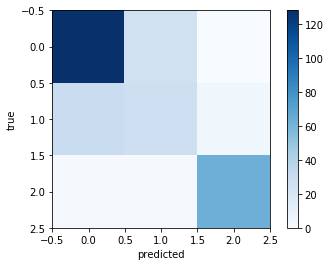

In [32]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

# Sample with all data

In [33]:
# Create tuples of all x coordinates and y coordinates 
x_coords = tuple(sample_pts_all.geometry.x)
y_coords = tuple(sample_pts_all.geometry.y)

In [34]:
# Use rasterio sample method to pull label numbers for 60% reference dataset. 
# kmeans_labeled_path = kmeans_outputs_path+kmeans_file+'_labeled.tif'
# Sample from labeled map (kmeans_labels)
sampled_values = []

# Sample raster at each combo of x and y coordinates
with rio.open(kmeans_labeled_path) as src:
#     src = np.squeeze(src)
    for val in src.sample(zip(x_coords, y_coords)):
        
        # Note that each val is an individual numpy array
        #print(val.shape)
        sampled_values.append(val)
        
# Convert list to one-dimensional array
arr = np.array([sampled_values]).squeeze()
# print(arr)

# Convert array to dataframe
# Dataframe includes label number for each reference point
kmeans_labeled_all_df = pd.DataFrame(arr)
kmeans_labeled_all_df.index=kmeans_labeled_all_df.index+1
kmeans_labeled_all_df.head()

,0
1,30795.0
2,30795.0
3,24820.0
4,25767.0
5,27261.0


In [35]:
# labels_valid_data = [kmeans_labels_df,valid_data]
labeled_valid_all_data_df = pd.concat([kmeans_labeled_all_df,all_valid_data], axis=1, sort=False)
labeled_valid_all_data_df.columns = ["labels","object_id","validation_data"]
labeled_valid_all_data_df = labeled_valid_all_data_df.drop_duplicates(subset="labels")
labeled_valid_all_data_df = labeled_valid_all_data_df.sort_values(by="labels")
# labels_clusters_df_nodups
# labels_valid_data_df.index=labels_valid_data_df.index+1
labeled_valid_all_data_df.head()

,labels,object_id,validation_data
875,27.0,876.0,3.0
902,38.0,903.0,3.0
84,108.0,85.0,1.0
897,159.0,898.0,3.0
83,195.0,84.0,1.0


In [36]:
# Subset props dataset to focus only on 60% validation data
subset_props_labels = props_df[props_df.index.isin(labeled_valid_all_data_df['labels'])]
# subset_props_labels = props_df.loc[props_df['labels_original']==labeled_valid_60_data_df['labels']]
# subset_props_labels = subset_props_labels.join(labels_clusters_df_nodups)     
subset_props_labels['labels']=subset_props_labels.index
# rst = rpt[rpt['STK_ID'].isin(stk_list)].
subset_props_labels.head()

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels
object_id,,,,,,,,,,,,,,,,,,,,,
27,98708,"(0, 0, 500, 1075)",537500,"(254.09218097823884, 487.70105766503224)",458985,0.923445,354.512241,-1057,0.183643,112255,...,1.0,1.0,1.0,458.785194,0.070743,39259.913903,0.215057,"(254.09218097823884, 487.70105766503224)",27,27
38,64193,"(0, 297, 332, 701)",134128,"(144.16297727166514, 485.4574486314707)",99494,0.249540,285.889955,-157,0.478595,75349,...,6.0,6.0,6.0,372.823977,0.704744,7718.476077,0.645195,"(144.16297727166514, 485.4574486314707)",38,38
108,145,"(0, 1040, 44, 1059)",836,"(23.26896551724138, 1048.3517241379311)",255,0.993505,13.587484,-1,0.173445,158,...,8.0,8.0,8.0,5.871097,1.238609,121.870058,0.568627,"(23.26896551724138, 1048.3517241379311)",108,108
159,11691,"(0, 1327, 145, 1640)",45385,"(70.49097596441707, 1505.030279702335)",27872,0.939195,122.005916,-86,0.257596,12117,...,4.0,4.0,4.0,110.610458,-0.049923,3530.747617,0.419453,"(70.49097596441707, 1505.030279702335)",159,159
195,29,"(1, 1049, 23, 1058)",198,"(12.068965517241379, 1052.6206896551723)",49,0.997840,6.076508,1,0.146465,29,...,3.0,3.0,3.0,1.684209,1.187798,28.485281,0.591837,"(12.068965517241379, 1052.6206896551723)",195,195


In [37]:
# Subset props dataset to focus only on 60% validation data
subset_props_labels = props_df[props_df.index.isin(labeled_valid_all_data_df['labels'])]
# subset_props_labels = props_df.loc[props_df['labels_original']==labeled_valid_60_data_df['labels']]
# subset_props_labels = subset_props_labels.join(labels_clusters_df_nodups)     
subset_props_labels['labels']=subset_props_labels.index
# rst = rpt[rpt['STK_ID'].isin(stk_list)].
subset_props_labels.head()

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,max_intensity,mean_intensity,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels
object_id,,,,,,,,,,,,,,,,,,,,,
27,98708,"(0, 0, 500, 1075)",537500,"(254.09218097823884, 487.70105766503224)",458985,0.923445,354.512241,-1057,0.183643,112255,...,1.0,1.0,1.0,458.785194,0.070743,39259.913903,0.215057,"(254.09218097823884, 487.70105766503224)",27,27
38,64193,"(0, 297, 332, 701)",134128,"(144.16297727166514, 485.4574486314707)",99494,0.249540,285.889955,-157,0.478595,75349,...,6.0,6.0,6.0,372.823977,0.704744,7718.476077,0.645195,"(144.16297727166514, 485.4574486314707)",38,38
108,145,"(0, 1040, 44, 1059)",836,"(23.26896551724138, 1048.3517241379311)",255,0.993505,13.587484,-1,0.173445,158,...,8.0,8.0,8.0,5.871097,1.238609,121.870058,0.568627,"(23.26896551724138, 1048.3517241379311)",108,108
159,11691,"(0, 1327, 145, 1640)",45385,"(70.49097596441707, 1505.030279702335)",27872,0.939195,122.005916,-86,0.257596,12117,...,4.0,4.0,4.0,110.610458,-0.049923,3530.747617,0.419453,"(70.49097596441707, 1505.030279702335)",159,159
195,29,"(1, 1049, 23, 1058)",198,"(12.068965517241379, 1052.6206896551723)",49,0.997840,6.076508,1,0.146465,29,...,3.0,3.0,3.0,1.684209,1.187798,28.485281,0.591837,"(12.068965517241379, 1052.6206896551723)",195,195


In [38]:
subset_props = pd.merge(subset_props_labels,labeled_valid_all_data_df, on='labels')
subset_props_60 = subset_props
subset_props.head()

# props_labels_clusters = subset_props_labels[subset_props_labels.index.isin(labels_clusters_df('labels'))].add(labels_clusters_df('clusters'))

# props_labels_clusters = subset_props_labels.merge(labels_clusters_df, on='labels')
# props_labels_clusters = labels_clusters_df.join(subset_props_labels.set_index('object_id').bar.rename('new'))

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels,object_id,validation_data
0,98708,"(0, 0, 500, 1075)",537500,"(254.09218097823884, 487.70105766503224)",458985,0.923445,354.512241,-1057,0.183643,112255,...,1.0,458.785194,0.070743,39259.913903,0.215057,"(254.09218097823884, 487.70105766503224)",27,27,876.0,3.0
1,64193,"(0, 297, 332, 701)",134128,"(144.16297727166514, 485.4574486314707)",99494,0.249540,285.889955,-157,0.478595,75349,...,6.0,372.823977,0.704744,7718.476077,0.645195,"(144.16297727166514, 485.4574486314707)",38,38,903.0,3.0
2,145,"(0, 1040, 44, 1059)",836,"(23.26896551724138, 1048.3517241379311)",255,0.993505,13.587484,-1,0.173445,158,...,8.0,5.871097,1.238609,121.870058,0.568627,"(23.26896551724138, 1048.3517241379311)",108,108,85.0,1.0
3,11691,"(0, 1327, 145, 1640)",45385,"(70.49097596441707, 1505.030279702335)",27872,0.939195,122.005916,-86,0.257596,12117,...,4.0,110.610458,-0.049923,3530.747617,0.419453,"(70.49097596441707, 1505.030279702335)",159,159,898.0,3.0
4,29,"(1, 1049, 23, 1058)",198,"(12.068965517241379, 1052.6206896551723)",49,0.997840,6.076508,1,0.146465,29,...,3.0,1.684209,1.187798,28.485281,0.591837,"(12.068965517241379, 1052.6206896551723)",195,195,84.0,1.0


In [39]:
accuracy_kmeans = pd.concat([subset_props['min_intensity'],subset_props['validation_data']], axis=1, sort=False)
# accuracy_score = pd.concat([valid_data,index_comb_df], axis=1, sort=False)
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 8.0,"new"] = class8
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 7.0,"new"] = class7
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 6.0,"new"] = class6
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 5.0,"new"] = class5
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 4.0,"new"] = class4
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 3.0,"new"] = class3
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 2.0,"new"] = class2
accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 1.0,"new"] = class1
accuracy_kmeans.head()

,min_intensity,validation_data,new
0,1.0,3.0,3.0
1,6.0,3.0,3.0
2,8.0,1.0,2.0
3,4.0,3.0,3.0
4,3.0,1.0,1.0


In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
ytest = accuracy_kmeans['validation_data']
ypred = accuracy_kmeans['new']
accuracy_score(ytest, ypred)

0.7798165137614679

[[238  42   0]
 [ 63  34   9]
 [  1   5 153]]


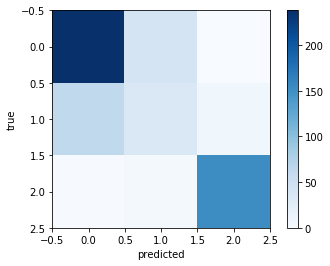

In [41]:
#Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))

plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

In [42]:
subset_props

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels,object_id,validation_data
0,98708,"(0, 0, 500, 1075)",537500,"(254.09218097823884, 487.70105766503224)",458985,0.923445,354.512241,-1057,0.183643,112255,...,1.0,458.785194,0.070743,39259.913903,0.215057,"(254.09218097823884, 487.70105766503224)",27,27,876.0,3.0
1,64193,"(0, 297, 332, 701)",134128,"(144.16297727166514, 485.4574486314707)",99494,0.249540,285.889955,-157,0.478595,75349,...,6.0,372.823977,0.704744,7718.476077,0.645195,"(144.16297727166514, 485.4574486314707)",38,38,903.0,3.0
2,145,"(0, 1040, 44, 1059)",836,"(23.26896551724138, 1048.3517241379311)",255,0.993505,13.587484,-1,0.173445,158,...,8.0,5.871097,1.238609,121.870058,0.568627,"(23.26896551724138, 1048.3517241379311)",108,108,85.0,1.0
3,11691,"(0, 1327, 145, 1640)",45385,"(70.49097596441707, 1505.030279702335)",27872,0.939195,122.005916,-86,0.257596,12117,...,4.0,110.610458,-0.049923,3530.747617,0.419453,"(70.49097596441707, 1505.030279702335)",159,159,898.0,3.0
4,29,"(1, 1049, 23, 1058)",198,"(12.068965517241379, 1052.6206896551723)",49,0.997840,6.076508,1,0.146465,29,...,3.0,1.684209,1.187798,28.485281,0.591837,"(12.068965517241379, 1052.6206896551723)",195,195,84.0,1.0
5,1,"(4, 1659, 5, 1660)",1,"(4.0, 1659.0)",1,0.000000,1.128379,1,1.000000,1,...,3.0,0.000000,0.785398,0.000000,1.000000,"(4.0, 1659.0)",282,282,735.0,1.0
6,47,"(15, 1204, 38, 1217)",299,"(27.06382978723404, 1209.8936170212767)",86,0.991439,7.735778,1,0.157191,47,...,8.0,3.701804,1.122373,47.798990,0.546512,"(27.06382978723404, 1209.8936170212767)",573,573,86.0,2.0
7,4196,"(19, 457, 109, 550)",8370,"(67.67063870352717, 494.9492373689228)",6140,0.581485,73.092497,-14,0.501314,4244,...,4.0,71.492623,-0.347906,752.559487,0.683388,"(67.67063870352717, 494.9492373689228)",668,668,906.0,3.0
8,6400,"(59, 1311, 195, 1565)",34544,"(134.705, 1449.88859375)",9966,0.991616,90.270333,-113,0.185271,6679,...,4.0,36.015403,-0.413481,1755.096680,0.642183,"(134.70499999999998, 1449.88859375)",1757,1757,897.0,3.0
9,15730,"(62, 1576, 500, 1788)",92856,"(310.10025429116337, 1705.0561983471075)",67386,0.929978,141.520522,-70,0.169402,16098,...,4.0,169.211878,-1.537175,4297.679687,0.233431,"(310.1002542911634, 1705.0561983471075)",1836,1836,862.0,3.0


### The cells below are an exploration into the three clusters which contain water and shadow for the 9-band stack kmeans result including the shadow_mask (MSI>0.12)

In [43]:
# Subset based on shadow, water, other
# shadow = subset_props.loc[subset_props['validation_data']==1]
# flood = subset_props.loc[subset_props['validation_data']==2]
# other = subset_props.loc[subset_props['validation_data']==3]

cluster_3 = subset_props.loc[subset_props['min_intensity']==3]
cluster_5 = subset_props.loc[subset_props['min_intensity']==5]
cluster_8 = subset_props.loc[subset_props['min_intensity']==8]

cluster_3_shadow = cluster_3.loc[cluster_3['validation_data']==1]
cluster_3_flood = cluster_3.loc[cluster_3['validation_data']==2]
cluster_3_other = cluster_3.loc[cluster_3['validation_data']==3]

cluster_5_shadow = cluster_5.loc[cluster_5['validation_data']==1]
cluster_5_flood = cluster_5.loc[cluster_5['validation_data']==2]
cluster_5_other = cluster_5.loc[cluster_5['validation_data']==3]

cluster_8_shadow = cluster_8.loc[cluster_8['validation_data']==1]
cluster_8_flood = cluster_8.loc[cluster_8['validation_data']==2]
cluster_8_other = cluster_8.loc[cluster_8['validation_data']==3]

In [44]:
print('cluster_3_shadow',cluster_3_shadow.shape)
print('cluster_3_flood',cluster_3_flood.shape)
print('cluster_3_other',cluster_3_other.shape)
print('')
print('cluster_5_shadow',cluster_5_shadow.shape)
print('cluster_5_flood',cluster_5_flood.shape)
print('cluster_5_other',cluster_5_other.shape)
print('')
print('cluster_8_shadow',cluster_8_shadow.shape)
print('cluster_8_flood',cluster_8_flood.shape)
print('cluster_8_other',cluster_8_other.shape)

cluster_3_shadow (154, 26)
cluster_3_flood (37, 26)
cluster_3_other (0, 26)

cluster_5_shadow (84, 26)
cluster_5_flood (26, 26)
cluster_5_other (1, 26)

cluster_8_shadow (42, 26)
cluster_8_flood (34, 26)
cluster_8_other (5, 26)


### Goal would be to try and re-organize so that cluster 3 and cluster 5 are shadow only, and cluster 8 is water. Need to go back and consider evening out reference file as potentiall too heavy on shadow points. 
- Seems that I lose a number of flood points as they are part of a continous labeled region while shadow points persist.

In [54]:
# flood.head()
cluster_8_shadow.head()

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels,object_id,validation_data
2,145,"(0, 1040, 44, 1059)",836,"(23.26896551724138, 1048.3517241379311)",255,0.993505,13.587484,-1,0.173445,158,...,8.0,5.871097,1.238609,121.870058,0.568627,"(23.26896551724138, 1048.3517241379311)",108,108,85.0,1.0
27,63,"(162, 1748, 190, 1759)",308,"(176.6031746031746, 1753.6666666666667)",104,0.992136,8.956232,1,0.204545,63,...,8.0,3.942178,1.233608,55.556349,0.605769,"(176.6031746031746, 1753.6666666666667)",5353,5353,309.0,1.0
29,2,"(164, 1760, 166, 1761)",2,"(164.5, 1760.0)",2,1.000000,1.595769,1,1.000000,2,...,8.0,0.000000,-1.570796,0.000000,1.000000,"(164.5, 1760.0)",5422,5422,308.0,1.0
34,288,"(183, 1388, 277, 1430)",3948,"(229.42013888888889, 1408.670138888889)",466,0.999323,19.149229,-4,0.072948,294,...,8.0,4.250620,1.165331,228.917785,0.618026,"(229.42013888888889, 1408.670138888889)",5974,5974,353.0,1.0
38,321,"(196, 1411, 315, 1464)",6307,"(255.71028037383178, 1437.3302180685357)",630,0.999442,20.216575,1,0.050896,321,...,8.0,4.949496,1.159670,316.876154,0.509524,"(255.71028037383178, 1437.3302180685357)",6391,6391,355.0,1.0


In [47]:
##### 
print('Cluster 3 Shadow Perimeter min,max,mean:',cluster_3_shadow['perimeter'].min(), cluster_3_shadow['perimeter'].max(), cluster_3_shadow['perimeter'].mean())
print('Cluster 3 Flood Perimeter min,max,mean:',cluster_3_flood['perimeter'].min(), cluster_3_flood['perimeter'].max(), cluster_3_flood['perimeter'].mean())
print('Cluster 3 Other Perimeter min,max,mean:',cluster_3_other['perimeter'].min(), cluster_3_other['perimeter'].max(), cluster_3_other['perimeter'].mean())
print('')
print('Cluster 5 Shadow Perimeter min,max,mean:',cluster_5_shadow['perimeter'].min(), cluster_5_shadow['perimeter'].max(), cluster_5_shadow['perimeter'].mean())
print('Cluster 5 Flood Perimeter min,max,mean:',cluster_5_flood['perimeter'].min(), cluster_5_flood['perimeter'].max(), cluster_5_flood['perimeter'].mean())
print('Cluster 5 Other Perimeter min,max,mean:',cluster_5_other['perimeter'].min(), cluster_5_other['perimeter'].max(), cluster_5_other['perimeter'].mean())
print('')
print('Cluster 8 Shadow Perimeter min,max,mean:',cluster_8_shadow['perimeter'].min(), cluster_8_shadow['perimeter'].max(), cluster_8_shadow['perimeter'].mean())
print('Cluster 8 Flood Perimeter min,max,mean:',cluster_8_flood['perimeter'].min(), cluster_8_flood['perimeter'].max(), cluster_8_flood['perimeter'].mean())
print('Cluster 8 Other Perimeter min,max,mean:',cluster_8_other['perimeter'].min(), cluster_8_other['perimeter'].max(), cluster_8_other['perimeter'].mean())

Cluster 3 Shadow Perimeter min,max,mean: 0.0 207.53300858899107 24.637979979287522
Cluster 3 Flood Perimeter min,max,mean: 0.0 298.5929291125633 66.88989602875822
Cluster 3 Other Perimeter min,max,mean: nan nan nan

Cluster 5 Shadow Perimeter min,max,mean: 11.313708498984761 169.3380951166243 54.224784795814045
Cluster 5 Flood Perimeter min,max,mean: 18.727922061357855 103.56854249492379 35.97403981753951
Cluster 5 Other Perimeter min,max,mean: 73.35533905932738 73.35533905932738 73.35533905932738

Cluster 8 Shadow Perimeter min,max,mean: 0.0 1412.6082604829626 186.85993859191817
Cluster 8 Flood Perimeter min,max,mean: 43.79898987322333 23439.655362198624 2138.9833056154075
Cluster 8 Other Perimeter min,max,mean: 165.1126983722081 378.50461735799473 239.63880938411793


### May be possible to threshold cluster 3 that any labeled region > 207 should be put into the cluster 8 

In [55]:
cluster_8_other.head()

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,min_intensity,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels,object_id,validation_data
12,1300,"(68, 923, 131, 968)",2835,"(97.62538461538462, 946.8407692307692)",1615,0.904820,40.684289,-16,0.458554,1394,...,8.0,29.292647,1.237993,378.504617,0.804954,"(97.62538461538462, 946.8407692307692)",1991,1991,901.0,3.0
16,366,"(92, 843, 149, 868)",1425,"(120.14207650273224, 856.103825136612)",702,0.968336,21.587165,-4,0.256842,378,...,8.0,14.483097,1.249393,198.302561,0.521368,"(120.14207650273224, 856.103825136612)",2861,2861,902.0,3.0
55,610,"(256, 538, 292, 576)",1368,"(271.51311475409835, 555.3065573770492)",914,0.864045,27.868910,-3,0.445906,615,...,8.0,21.813026,-0.549840,206.066017,0.667396,"(271.51311475409835, 555.3065573770492)",8171,8171,905.0,3.0
339,1957,"(942, 292, 1001, 344)",3068,"(967.8829841594277, 316.4695963208993)",2272,0.642603,49.917229,-4,0.637875,1966,...,8.0,45.890667,1.057425,250.208153,0.861356,"(967.8829841594277, 316.4695963208993)",38051,38051,799.0,3.0
473,264,"(1165, 977, 1207, 1000)",966,"(1180.1969696969697, 987.780303030303)",584,0.906202,18.333991,1,0.273292,264,...,8.0,18.303201,-1.115568,165.112698,0.452055,"(1180.1969696969697, 987.780303030303)",48491,48491,784.0,3.0


Appears like the one region in cluster_5_flood should be re-assigned to cluster 8, then all of cluster_5 can be defined as shadow. 

In [49]:
##### 
print('Cluster 3 Shadow equivalent_diameter min,max,mean:',cluster_3_shadow['equivalent_diameter'].min(), cluster_3_shadow['equivalent_diameter'].max(), cluster_3_shadow['equivalent_diameter'].mean())
print('Cluster 3 Flood equivalent_diameter min,max,mean:',cluster_3_flood['equivalent_diameter'].min(), cluster_3_flood['equivalent_diameter'].max(), cluster_3_flood['equivalent_diameter'].mean())
print('Cluster 3 Other equivalent_diameter min,max,mean:',cluster_3_other['equivalent_diameter'].min(), cluster_3_other['equivalent_diameter'].max(), cluster_3_other['equivalent_diameter'].mean())
print('')
print('Cluster 5 Shadow equivalent_diameter min,max,mean:',cluster_5_shadow['equivalent_diameter'].min(), cluster_5_shadow['equivalent_diameter'].max(), cluster_5_shadow['equivalent_diameter'].mean())
print('Cluster 5 Flood equivalent_diameter min,max,mean:',cluster_5_flood['equivalent_diameter'].min(), cluster_5_flood['equivalent_diameter'].max(), cluster_5_flood['equivalent_diameter'].mean())
print('Cluster 5 Other equivalent_diameter min,max,mean:',cluster_5_other['equivalent_diameter'].min(), cluster_5_other['equivalent_diameter'].max(), cluster_5_other['equivalent_diameter'].mean())
print('')
print('Cluster 8 Shadow equivalent_diameter min,max,mean:',cluster_8_shadow['equivalent_diameter'].min(), cluster_8_shadow['equivalent_diameter'].max(), cluster_8_shadow['equivalent_diameter'].mean())
print('Cluster 8 Flood equivalent_diameter min,max,mean:',cluster_8_flood['equivalent_diameter'].min(), cluster_8_flood['equivalent_diameter'].max(), cluster_8_flood['equivalent_diameter'].mean())
print('Cluster 8 Other equivalent_diameter min,max,mean:',cluster_8_other['equivalent_diameter'].min(), cluster_8_other['equivalent_diameter'].max(), cluster_8_other['equivalent_diameter'].mean())

Cluster 3 Shadow equivalent_diameter min,max,mean: 1.1283791670955126 19.44613444328572 5.2677874398675995
Cluster 3 Flood equivalent_diameter min,max,mean: 1.5957691216057308 38.530472475187736 12.042741899450245
Cluster 3 Other equivalent_diameter min,max,mean: nan nan nan

Cluster 5 Shadow equivalent_diameter min,max,mean: 4.068428945128219 24.410573670769317 10.974804407612286
Cluster 5 Flood equivalent_diameter min,max,mean: 6.4820448144285745 18.089294154193436 9.800413717928883
Cluster 5 Other equivalent_diameter min,max,mean: 14.884343478431232 14.884343478431232 14.884343478431232

Cluster 8 Shadow equivalent_diameter min,max,mean: 1.5957691216057308 60.47101762397742 15.610149354648419
Cluster 8 Flood equivalent_diameter min,max,mean: 7.735777827895049 273.8476509765171 56.004634976683164
Cluster 8 Other equivalent_diameter min,max,mean: 18.333991376950163 49.91722938071296 31.67831687207066


## May be possible to reassign labeled regions with equivalent diameter > 19.44 to flood (?) 
Issues with "other"?
## May be possible to reassign labeled regions with eq. diameter < 7.7 to shadow

In [50]:
##### 
print('Cluster 3 Shadow area min,max,mean:',cluster_3_shadow['area'].min(), cluster_3_shadow['area'].max(), cluster_3_shadow['area'].mean())
print('Cluster 3 Flood area min,max,mean:',cluster_3_flood['area'].min(), cluster_3_flood['area'].max(), cluster_3_flood['area'].mean())
print('Cluster 3 Other area min,max,mean:',cluster_3_other['area'].min(), cluster_3_other['area'].max(), cluster_3_other['area'].mean())
print('')
print('Cluster 5 Shadow area min,max,mean:',cluster_5_shadow['area'].min(), cluster_5_shadow['area'].max(), cluster_5_shadow['area'].mean())
print('Cluster 5 Flood area min,max,mean:',cluster_5_flood['area'].min(), cluster_5_flood['area'].max(), cluster_5_flood['area'].mean())
print('Cluster 5 Other area min,max,mean:',cluster_5_other['area'].min(), cluster_5_other['area'].max(), cluster_5_other['area'].mean())
print('')
print('Cluster 8 Shadow area min,max,mean:',cluster_8_shadow['area'].min(), cluster_8_shadow['area'].max(), cluster_8_shadow['area'].mean())
print('Cluster 8 Flood area min,max,mean:',cluster_8_flood['area'].min(), cluster_8_flood['area'].max(), cluster_8_flood['area'].mean())
print('Cluster 8 Other area min,max,mean:',cluster_8_other['area'].min(), cluster_8_other['area'].max(), cluster_8_other['area'].mean())

Cluster 3 Shadow area min,max,mean: 1 297 30.22077922077922
Cluster 3 Flood area min,max,mean: 2 1166 167.02702702702703
Cluster 3 Other area min,max,mean: nan nan nan

Cluster 5 Shadow area min,max,mean: 13 468 119.0
Cluster 5 Flood area min,max,mean: 33 257 82.34615384615384
Cluster 5 Other area min,max,mean: 174 174 174.0

Cluster 8 Shadow area min,max,mean: 2 2872 319.1904761904762
Cluster 8 Flood area min,max,mean: 47 58899 5440.85294117647
Cluster 8 Other area min,max,mean: 264 1957 899.4


## Cluster 3 - Reassign labeled regions with area > 297 to flood
## Cluster 8 - Reassign labeled regions with area < 47 to shadow

In [63]:
trial_cluster_8 = cluster_8
trial_cluster_8.loc[trial_cluster_8['area'] <47,"new_cluster"] = 3
trial_cluster_8

trial_cluster_3 = cluster_3
trial_cluster_3.loc[trial_cluster_3['area'] >297,"new_cluster"] = 8
trial_cluster_3
# accuracy_kmeans.loc[accuracy_kmeans['min_intensity'] == 7.0,"new"] = class7
cluster_3

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,filled_area,...,minor_axis_length,orientation,perimeter,solidity,weighted_centroid,labels_original,labels,object_id,validation_data,new_cluster
4,29,"(1, 1049, 23, 1058)",198,"(12.068965517241379, 1052.6206896551723)",49,0.997840,6.076508,1,0.146465,29,...,1.684209,1.187798,28.485281,0.591837,"(12.068965517241379, 1052.6206896551723)",195,195,84.0,1.0,NaN
5,1,"(4, 1659, 5, 1660)",1,"(4.0, 1659.0)",1,0.000000,1.128379,1,1.000000,1,...,0.000000,0.785398,0.000000,1.000000,"(4.0, 1659.0)",282,282,735.0,1.0,NaN
13,195,"(71, 725, 96, 743)",450,"(83.50769230769231, 733.5794871794872)",259,0.827630,15.756958,1,0.433333,195,...,13.192476,0.977798,75.597980,0.752896,"(83.50769230769231, 733.5794871794872)",2080,2080,658.0,2.0,NaN
18,253,"(131, 699, 174, 714)",645,"(148.95652173913044, 706.4308300395257)",418,0.966570,17.947969,0,0.392248,254,...,10.228590,1.401466,117.254834,0.605263,"(148.95652173913044, 706.4308300395257)",4280,4280,664.0,2.0,NaN
20,80,"(132, 1253, 181, 1275)",1078,"(153.4125, 1264.5125)",142,0.999300,10.092530,1,0.074212,80,...,2.103387,1.166659,75.349242,0.563380,"(153.4125, 1264.5125)",4324,4324,358.0,1.0,NaN
22,2,"(145, 1424, 147, 1425)",2,"(145.5, 1424.0)",2,1.000000,1.595769,1,1.000000,2,...,0.000000,-1.570796,0.000000,1.000000,"(145.5, 1424.0)",4815,4815,364.0,1.0,NaN
23,4,"(148, 1422, 152, 1424)",8,"(149.5, 1422.5)",5,0.985171,2.256758,1,0.500000,4,...,0.828427,1.178097,2.414214,0.800000,"(149.5, 1422.5)",4915,4915,365.0,1.0,NaN
24,6,"(154, 1761, 160, 1765)",24,"(156.5, 1762.5)",8,0.994180,2.763953,1,0.250000,6,...,0.838884,1.067056,4.828427,0.750000,"(156.5, 1762.5)",5116,5116,307.0,1.0,NaN
28,17,"(163, 1754, 177, 1760)",84,"(169.41176470588235, 1756.9411764705883)",25,0.996594,4.652426,1,0.202381,17,...,1.374121,1.187750,15.621320,0.680000,"(169.41176470588235, 1756.9411764705883)",5389,5389,310.0,1.0,NaN
30,124,"(172, 1364, 239, 1395)",2077,"(206.73387096774192, 1377.8951612903227)",199,0.999691,12.565099,1,0.059701,124,...,2.067492,1.159805,118.242641,0.623116,"(206.73387096774195, 1377.8951612903227)",5667,5667,314.0,1.0,NaN


In [51]:
##### shape_index = perimeter/(4*sqrt(A))
cluster_3_shadow_shape_index = cluster_3_shadow['perimeter']/(4*(cluster_3_shadow['area'].pow(1./2)))
cluster_3_flood_shape_index = cluster_3_flood['perimeter']/(4*(cluster_3_flood['area'].pow(1./2)))
cluster_3_other_shape_index = cluster_3_other['perimeter']/(4*(cluster_3_other['area'].pow(1./2)))

print('Cluster 3 Shadow shape_index min,max,mean:', cluster_3_shadow_shape_index.min(), cluster_3_shadow_shape_index.max(), cluster_3_shadow_shape_index.mean())
print('Cluster 3 Flood shape_index min,max,mean:', cluster_3_flood_shape_index.min(), cluster_3_flood_shape_index.max(), cluster_3_flood_shape_index.mean())
print('Cluster 3 Other shape_index min,max,mean:', cluster_3_other_shape_index.min(), cluster_3_other_shape_index.max(), cluster_3_other_shape_index.mean())
#       (cluster_3_shadow['perimeter']/(4*(cluster_3_shadow['area'].pow(1./2)))).min())#, cluster_3_shadow['area'].max(), cluster_3_shadow['area'].mean())
# print('Cluster 3 Flood area min,max,mean:',cluster_3_flood['area'].min(), cluster_3_flood['area'].max(), cluster_3_flood['area'].mean())
# print('Cluster 3 Other area min,max,mean:',cluster_3_other['area'].min(), cluster_3_other['area'].max(), cluster_3_other['area'].mean())
# print('')
# print('Cluster 5 Shadow area min,max,mean:',cluster_5_shadow['area'].min(), cluster_5_shadow['area'].max(), cluster_5_shadow['area'].mean())
# print('Cluster 5 Flood area min,max,mean:',cluster_5_flood['area'].min(), cluster_5_flood['area'].max(), cluster_5_flood['area'].mean())
# print('Cluster 5 Other area min,max,mean:',cluster_5_other['area'].min(), cluster_5_other['area'].max(), cluster_5_other['area'].mean())

Cluster 3 Shadow shape_index min,max,mean: 0.0 3.0105716390504393 0.9463310680624836
Cluster 3 Flood shape_index min,max,mean: 0.0 2.829533942334105 1.3052390338823237
Cluster 3 Other shape_index min,max,mean: nan nan nan


In [52]:
# Code below from initial explorations using flood, shadow, other validation data from all clusters. 

In [53]:
print('Shadow Perimeter min,max,mean:',shadow['perimeter'].min(), shadow['perimeter'].max(), shadow['perimeter'].mean())
print('Flood Perimeter min,max,mean:',flood['perimeter'].min(), flood['perimeter'].max(), flood['perimeter'].mean())

NameError: name 'shadow' is not defined

In [ ]:
print('Shadow Area min,max,mean:',shadow['area'].min(), shadow['area'].max(), shadow['area'].mean())
print('Flood Area min,max,mean:',flood['area'].min(), flood['area'].max(), flood['area'].mean())

In [ ]:
print('Shadow Area min,max,mean:',shadow['filled_area'].min(), shadow['filled_area'].max(), shadow['filled_area'].mean())
print('Flood Area min,max,mean:',flood['filled_area'].min(), flood['filled_area'].max(), flood['filled_area'].mean())

In [ ]:
print('Shadow Convex Area min,max,mean:',shadow['convex_area'].min(), shadow['convex_area'].max(), shadow['convex_area'].mean())
print('Flood Convex Area min,max,mean:',flood['convex_area'].min(), flood['convex_area'].max(), flood['convex_area'].mean())

In [ ]:
print('Shadow bbox Area min,max,mean:',shadow['bbox_area'].min(), shadow['bbox_area'].max(), shadow['bbox_area'].mean())
print('Flood bbox Area min,max,mean:',flood['bbox_area'].min(), flood['bbox_area'].max(), flood['bbox_area'].mean())

In [ ]:
print('Shadow Extent min,max,mean:',shadow['extent'].min(), shadow['extent'].max(), shadow['extent'].mean())
print('Flood Extent min,max,mean:',flood['extent'].min(), flood['extent'].max(), flood['extent'].mean())

In [ ]:
print('Shadow Minor Axis Length min,max,mean:',shadow['minor_axis_length'].min(), shadow['minor_axis_length'].max(), shadow['minor_axis_length'].mean())
print('Flood Minor Axis Length min,max,mean:',flood['minor_axis_length'].min(), flood['minor_axis_length'].max(), flood['minor_axis_length'].mean())

In [ ]:
print('Shadow minor_axis_length min,max,mean:',shadow['minor_axis_length'].min(), shadow['minor_axis_length'].max(), shadow['minor_axis_length'].mean())
print('Flood minor_axis_length  min,max,mean:',flood['minor_axis_length'].min(), flood['minor_axis_length'].max(), flood['minor_axis_length'].mean())

In [ ]:
print('Shadow Major Axis Length min,max,mean:',shadow['major_axis_length'].min(), shadow['major_axis_length'].max(), shadow['major_axis_length'].mean())
print('Flood Major Axis Length min,max,mean:',flood['major_axis_length'].min(), flood['major_axis_length'].max(), flood['major_axis_length'].mean())

In [ ]:
print('Shadow Equilavent Diameter min,max,mean:',shadow['equivalent_diameter'].min(), shadow['equivalent_diameter'].max(), shadow['equivalent_diameter'].mean())
print('Flood Equilavent Diameter  min,max,mean:',flood['equivalent_diameter'].min(), flood['equivalent_diameter'].max(), flood['equivalent_diameter'].mean())

In [ ]:
print('Shadow Euler Number min,max,mean:',shadow['euler_number'].min(), shadow['euler_number'].max(), shadow['euler_number'].mean())
print('Flood Euler Number  min,max,mean:',flood['euler_number'].min(), flood['euler_number'].max(), flood['euler_number'].mean())

In [ ]:
print('Shadow Area solidity min,max,mean:',shadow['solidity'].min(), shadow['solidity'].max(), shadow['solidity'].mean())
print('Flood Area solidity min,max,mean:',flood['solidity'].min(), flood['solidity'].max(), flood['solidity'].mean())

In [ ]:
shadow['test']=(shadow.major_axis_length/shadow.minor_axis_length)
flood['test']=(flood.major_axis_length/flood.minor_axis_length)
# print('Flood Perimeter/Area min,max,mean:',(flood.perimeter*flood.perimeter/flood.area).min(), (flood.perimeter*flood.perimeter/flood.area).max(), (flood.perimeter*flood.perimeter/flood.area).mean())


print('Shadow Major/Minor min,max,mean:',shadow['test'].min(), shadow['test'].max(), shadow['test'].mean())
print('Flood Major/Minor min,max,mean:',flood['test'].min(), flood['test'].max(), flood['test'].mean())

In [ ]:
shadow['new']=(shadow.perimeter*shadow.perimeter/shadow.area)
flood['new']=(flood.perimeter*flood.perimeter/flood.area)
# print('Flood Perimeter/Area min,max,mean:',(flood.perimeter*flood.perimeter/flood.area).min(), (flood.perimeter*flood.perimeter/flood.area).max(), (flood.perimeter*flood.perimeter/flood.area).mean())


print('Shadow Perimeter/Area min,max,mean:',(shadow['perimeter']*shadow['perimeter']/shadow['area']).min(), (shadow['perimeter']*shadow['perimeter']/shadow['area']).max(), (shadow['perimeter']*shadow['perimeter']/shadow['area']).mean())
print('Flood Perimeter/Area min,max,mean:',(flood['perimeter']*flood['perimeter']/flood['area']).min(), (flood['perimeter']*flood['perimeter']/flood['area']).max(), (flood['perimeter']*flood['perimeter']/flood['area']).mean())

In [ ]:
shadow.hist(column='new', bins=100)

In [ ]:
flood.hist(column='new', bins=100)

In [ ]:
shadow.hist(column='area', bins=100)

In [ ]:
flood.hist(column='area', bins=100)